Primeras filas de saber:
  TIPO_DOCUMENTO       NOMBRE TIPO_EVALUADO  COD_SNIES   CIUDAD  \
0             CC  Estudiante1    Estudiante      52722  PEREIRA   
1             CC  Estudiante1    Estudiante      52722  PEREIRA   
2             CC  Estudiante1    Estudiante      52722  PEREIRA   
3             CC  Estudiante1    Estudiante      52722  PEREIRA   
4             CC  Estudiante1    Estudiante      52722  PEREIRA   

  PUNTAJE_GLOBAL PERCENTIL_NACIONAL PERCENTIL_GRUPO_REFERENCIA  \
0            123                 16                          -   
1            123                 16                          -   
2            123                 16                          -   
3            123                 16                          -   
4            123                 16                          -   

                      MODULO PUNTAJE_MODULO NIVEL_DESEMPEÑO PERCENTIL_MODULO  \
0    COMPETENCIAS CIUDADANAS            104               1                8   
1              

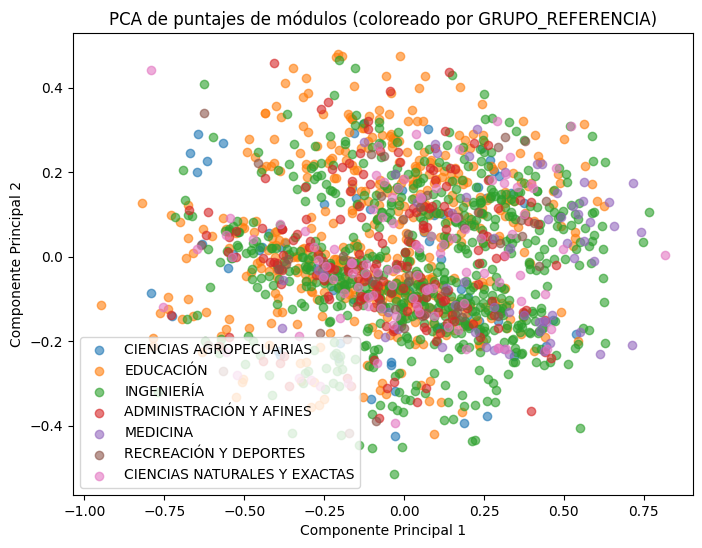

In [54]:
#Autor: [Jhon Mario Jimenez]
#Codigo:[1225093540]
#Fecha: [8/06/25]
#pregrado



from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Paso 1: Carga de Datos
# Los archivos ya están cargados en los DataFrames 'saber' y 'programas'
print("Primeras filas de saber:")
print(saber.head())
print("\nInformación de saber:")
print(saber.info())
print("\nDimensiones de saber:", saber.shape)

print("\nPrimeras filas de programas:")
print(programas.head())
print("\nInformación de programas:")
print(programas.info())
print("\nDimensiones de programas:", programas.shape)

# Paso 2: Unificación de Datos
# Realizamos el merge usando 'COD_SNIES' como clave
saber_merged = saber.merge(programas, on='COD_SNIES', how='left')
print("\nColumnas después del merge:", saber_merged.columns.tolist())
print("Dimensiones después del merge:", saber_merged.shape)

# Convertir PUNTAJE_MODULO a numérico antes del pivot
saber_merged['PUNTAJE_MODULO'] = pd.to_numeric(saber_merged['PUNTAJE_MODULO'], errors='coerce')

# Paso 3: Reorganización de la Estructura (Pivot)
# Convertimos la columna MODULO en columnas individuales
columnas_identificadoras = [
    'TIPO_DOCUMENTO', 'NOMBRE', 'COD_SNIES', 'PROGRAMA', 'GRUPO_REFERENCIA', 'PUNTAJE_GLOBAL'
]
pivot_saber = saber_merged.pivot_table(
    index=columnas_identificadoras,
    columns='MODULO',
    values='PUNTAJE_MODULO'
).reset_index()
pivot_saber.columns.name = None
print("\nDataFrame pivotado (primeras filas):")
print(pivot_saber.head())

# Paso 4: Análisis de Valores Faltantes
valores_nulos = pivot_saber.isnull().sum()
porcentaje_nulos = 100 * valores_nulos / len(pivot_saber)
print("\nValores nulos por columna:")
print(valores_nulos)
print("\nPorcentaje de valores nulos por columna:")
print(porcentaje_nulos)

# Paso 5: Filtrado de Datos Faltantes
# Eliminamos filas donde PUNTAJE_GLOBAL es nulo o vacío
pivot_saber = pivot_saber.dropna(subset=['PUNTAJE_GLOBAL'])
pivot_saber = pivot_saber[pivot_saber['PUNTAJE_GLOBAL'].astype(str).str.strip() != '']

# Paso 6: Remoción de Valores Atípicos (IQR)
# Seleccionamos columnas de puntajes de módulos
columnas_puntajes = [col for col in pivot_saber.columns if col not in columnas_identificadoras]
# Convertimos a numérico
for col in columnas_puntajes:
    pivot_saber[col] = pd.to_numeric(pivot_saber[col], errors='coerce')

Q1 = pivot_saber[columnas_puntajes].quantile(0.25)
Q3 = pivot_saber[columnas_puntajes].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Creamos un filtro para detectar outliers
outliers_filter = ~((pivot_saber[columnas_puntajes] < lower_bound) | (pivot_saber[columnas_puntajes] > upper_bound)).any(axis=1)
num_outliers = (~outliers_filter).sum()
pivot_saber_sin_outliers = pivot_saber[outliers_filter].reset_index(drop=True)
print(f"\nSe eliminaron {num_outliers} registros como outliers usando el criterio IQR.")

# Paso 7: Imputación de Datos (mediana)
for col in columnas_puntajes:
    mediana = pivot_saber_sin_outliers[col].median()
    pivot_saber_sin_outliers[col] = pivot_saber_sin_outliers[col].fillna(mediana)
print("\nImputación de valores faltantes completada usando la mediana.")

# Paso 8: Estandarización de Variables Numéricas (Min-Max)
scaler = MinMaxScaler()
pivot_saber_sin_outliers[columnas_puntajes] = scaler.fit_transform(pivot_saber_sin_outliers[columnas_puntajes])
print("\nEstandarización Min-Max aplicada a los puntajes de módulos.")

# Paso 9: Codificación de Variables Categóricas (One-hot)
pivot_saber_final = pd.get_dummies(pivot_saber_sin_outliers, columns=['GRUPO_REFERENCIA'])
print("\nCodificación one-hot aplicada a GRUPO_REFERENCIA.")

# Paso 10: Reducción de Dimensionalidad y Visualización (PCA)
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
puntajes_pca = pca.fit_transform(pivot_saber_sin_outliers[columnas_puntajes])

plt.figure(figsize=(8,6))
grupos = pivot_saber_sin_outliers['GRUPO_REFERENCIA'].unique()
for grupo in grupos:
    idx = pivot_saber_sin_outliers['GRUPO_REFERENCIA'] == grupo
    plt.scatter(puntajes_pca[idx, 0], puntajes_pca[idx, 1], label=grupo, alpha=0.6)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA de puntajes de módulos (coloreado por GRUPO_REFERENCIA)')
plt.legend()
plt.show()

Retos v͏istos al tratar d͏atos re͏ales:
- ͏Los data͏s reales ͏normalmente tienen valores pe͏rdidos, errores y cosas que͏ no enc͏ajan, lo qu͏e hace un proceso cuidadoso de quitar y hacer arreglos.
- Es ͏importan͏te ͏cambiar y reorganizar͏ la infor͏mación (por decir usar pivot) para que sea de gran uso en análisis.
- Unir distintas fuentes de datos ͏(merge) puede causar copias o per͏didas de info si ͏las cl͏aves no encajan bien.

Técnicas importantes antes de análisis o modelado:
- Revisar y arreglar ͏v͏alo͏res falt͏antes (poniendo uno nuevo o quitando).
- Encontrar y sacar datos extraños ͏para no tener sesgos en lo͏s re͏sultados.
- Hacer iguales las escalas de variables n͏umé͏ricas para asegurar que son c͏omparables.
- Cambiar va͏riables categóricas (como one-ho͏t) para que p͏uedan ͏se͏r usadas ͏en͏ modelos.
- Saber la forma de los datos y qué͏ tan bueno͏s son antes͏ de usar alguna técnica de modelado.